# Approximate $\tau_0$ and scale the burst drift

$ \tau_0 \simeq \frac{b}{\cos\theta} $ Where $b$ is the minor axis of the gaussian fit to the burst autocorrelation.
Then, if $d\nu_{\text{obs}} / dt_{\text{obs}}$ is the burst drift, we expect 


### $\frac{d\nu_{\text{obs}}}{dt_{\text{obs}}}=\frac{\nu_{\text{obs}}^{2}}{\nu_{0}\tau_{0}}\simeq\frac{\nu_{\text{obs}}^{2}b}{\nu_{0}\cos\theta}$

In [11]:
import numpy as np
import scipy.stats
import scipy.odr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from tqdm import tqdm
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd

bursts121102 = pd.read_csv('../bursts.csv')
bursts121102 = bursts121102.set_index('name')

bursts180916 = pd.merge(pd.read_csv('data/CHIME_180916_imgs/chime_180916_fit_params.csv'),
         pd.read_csv('data/CHIME_180916_imgs/chime_180916_param_errors.csv'),
         how='left', on='name')
bursts180916 = bursts180916.set_index('name')

## Correct sigmax and sigmay for pixel scale
bursts180916['sigmax'] = bursts180916[['sigmaxp', 'xscale']].apply(lambda row: abs(row['sigmaxp'])/row['xscale'], axis=1)
bursts180916['sigmay'] = bursts180916[['sigmayp', 'yscale']].apply(lambda row: abs(row['sigmayp'])/row['yscale'], axis=1)
bursts180916['sigmax_error'] = bursts180916[['sigmaxp_error', 'xscale']].apply(lambda row: abs(row['sigmaxp_error'])/row['xscale'], axis=1)
bursts180916['sigmay_error'] = bursts180916[['sigmayp_error', 'yscale']].apply(lambda row: abs(row['sigmayp_error'])/row['yscale'], axis=1)

In [9]:
bursts121102

,filename,edge,angle,peak,sigmax,sigmay,Slope,drift (mhz/ms),drift error (mhz/ms),center,...,drift_abs,min_sigma,max_sigma,min_sigma_error,max_sigma_error,sigma_t,tau_w,tau_w_error,sigma_t_ms,tau_w_ms
name,,,,,,,,,,,,,,,,,,,,,
M1,01_puppi_57747_C0531+33_0558_5.dm559.72.calibP...,1525.0,1.720000,1.042900e+04,173.731526,47.364587,-6.652439,-1039.359422,0.190767,228.755888,...,1039.359422,47.364587,173.731526,0.003007,0.011140,0.000485,0.000490,0.000101,0.485013,0.490051
M2,02_puppi_57747_C0531+33_0558_1183.dm559.72.cal...,1850.0,1.780000,5.692000e+03,177.080918,44.911875,-4.736866,-740.578566,0.652317,209.060564,...,740.578566,44.911875,177.080918,0.020486,0.081784,0.000460,0.000469,0.000650,0.459898,0.469468
M3,03_puppi_57747_C0531+33_0558_1202.dm559.72.cal...,1975.0,1.620000,5.668000e+03,169.749001,19.463885,-19.669528,-2823.770453,2.623174,249.051665,...,2823.770453,19.463885,169.749001,0.005950,0.052822,0.000199,0.000200,0.000495,0.199310,0.199549
M4,04_puppi_57747_C0531+33_0558_25437.dm559.72.ca...,1450.0,1.710000,5.038000e+03,160.360329,26.706231,-7.137257,-1104.756403,21.768613,322.029396,...,1104.756403,26.706231,160.360329,0.292807,1.780140,0.000273,0.000276,0.014013,0.273472,0.276068
M5,05_puppi_57747_C0531+33_0558_3683.dm559.72.cal...,1450.0,1.639204,5.031000e+03,37.747383,166.280492,-14.595503,-2111.819665,67.749909,214.396765,...,2111.819665,37.747383,166.280492,0.258022,1.153948,0.000387,0.000387,0.011306,0.386533,0.387393
M6,06_puppi_57747_C0531+33_0558_3687.dm559.72.cal...,1150.0,1.590000,5.569000e+03,156.557708,12.416683,-52.066970,-6051.049490,11.249634,263.938012,...,6051.049490,12.416683,156.557708,0.005173,0.065385,0.000127,0.000127,0.000650,0.127147,0.127170
M7,07_puppi_57747_C0531+33_0558_3688.dm559.72.cal...,1590.0,1.720000,5.821000e+03,102.259272,38.969184,-6.652439,-1019.972935,0.845772,160.167242,...,1019.972935,38.969184,102.259272,0.007547,0.019954,0.000399,0.000403,0.000192,0.399044,0.402867
M8,08_puppi_57747_C0531+33_0558_3689.dm559.72.cal...,2000.0,1.990000,5.666000e+03,171.395398,64.792725,-2.244076,-340.369797,0.064490,296.067560,...,340.369797,64.792725,171.395398,0.007370,0.019619,0.000663,0.000716,0.000141,0.663478,0.716279
M9,09_puppi_57747_C0531+33_0558_3690.dm559.72.cal...,1600.0,2.240000,5.041000e+03,133.024941,89.628038,-1.264288,-191.720931,5.297999,216.215087,...,191.720931,89.628038,133.024941,0.697559,1.038778,0.000918,0.001033,0.008734,0.917791,1.032688


## Compute 121102 details

Text(0.5, 0, 'Burst #')

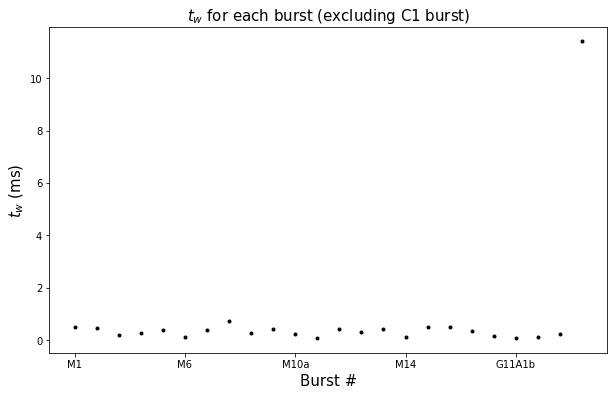

In [5]:
bursts121102['drift_abs'] = abs(bursts121102['drift (mhz/ms)'])
bursts121102['min_sigma'] = bursts121102[['sigmax','sigmay']].apply(lambda row: min(row['sigmax'], row['sigmay']), axis=1)
bursts121102['max_sigma'] = bursts121102[['sigmax','sigmay']].apply(lambda row: max(row['sigmax'], row['sigmay']), axis=1)
# the following two lines assume that if sigmax > sigmay, then sigmax_error > sigmay_error, which is true (so far) for this dataset
bursts121102['min_sigma_error'] = bursts121102[['sigmax_error','sigmay_error']].apply(lambda row: min(row['sigmax_error'], row['sigmay_error']), axis=1)
bursts121102['max_sigma_error'] = bursts121102[['sigmax_error','sigmay_error']].apply(lambda row: max(row['sigmax_error'], row['sigmay_error']), axis=1)

bursts121102['sigma_t']   = bursts121102[['min_sigma','time_res']].apply(lambda row: row['min_sigma']*row['time_res'], axis=1)

bursts121102['tau_w'] = bursts121102[['time_res', 'min_sigma', 'max_sigma', 'angle']].apply(
    lambda r: r['time_res']*r['min_sigma']*r['max_sigma'] / np.sqrt( np.abs((np.sin(r['angle']-np.pi/2)*r['min_sigma'])**2 + (np.cos(r['angle']-np.pi/2)*r['max_sigma'])**2 )), 
    axis=1
)

# this error is in ms
bursts121102['tau_w_error'] = bursts121102[['time_res', 'min_sigma', 'max_sigma', 'min_sigma_error', 'max_sigma_error', 'angle', 'angle_error']].apply(
    lambda r: 1e3*r['time_res']*np.sqrt((r['angle_error']**2*r['max_sigma']**2*r['min_sigma']**2*(2*r['max_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2) - 2*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2))**2)/(4.*(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**3)+ r['min_sigma_error']**2*(-((r['max_sigma']*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['max_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2+ r['max_sigma_error']**2*(-((r['max_sigma']**2*r['min_sigma']*np.sin(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['min_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2),
    axis=1
)

bursts121102['sigma_t_ms'] = bursts121102['sigma_t']*1e3
bursts121102['tau_w_ms'] = bursts121102['tau_w']*1e3

## C1 
bursts121102.at['C1', 'tau_w_ms'] = 11.4
bursts121102.at['C1', 'tau_w'] = 11.4/1000
bursts121102.at['C1', 'tau_w_error'] = 0.12

bursts121102_to_include = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9a', 'M9b', 'M10a', 'M10b', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'G11D', 'G11A1a', 'G11A1b', 'G11A2', 'G11A3', 'C1']
fontsize=15

selectbursts121102 = bursts121102.loc[bursts121102_to_include]
ax = selectbursts121102['tau_w_ms'].plot(style='k.', figsize=(10,6))
ax.set_title("$t_w$ for each burst (excluding C1 burst)", size=fontsize)
ax.set_ylabel('$t_w$ (ms)', size=fontsize)
ax.set_xlabel('Burst #', size=fontsize)
# plt.savefig('tw.png')

## Compute 180916 details

Text(0.5, 0, 'Burst #')

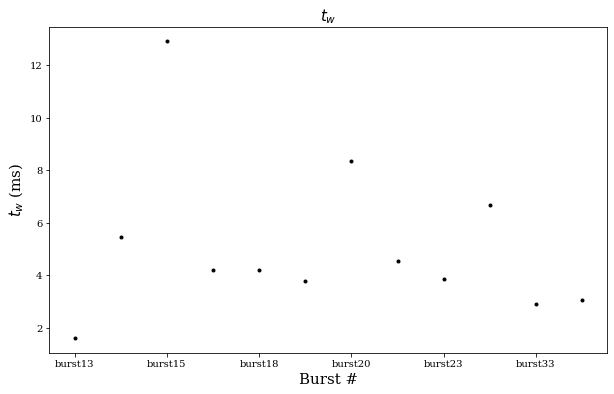

In [17]:
bursts180916['drift_abs'] = abs(bursts180916['drift (mhz/ms)'])
bursts180916['min_sigma'] = bursts180916[['sigmax','sigmay']].apply(lambda row: min(row['sigmax'], row['sigmay']), axis=1)
bursts180916['max_sigma'] = bursts180916[['sigmax','sigmay']].apply(lambda row: max(row['sigmax'], row['sigmay']), axis=1)
# the following two lines assume that if sigmax > sigmay, then sigmax_error > sigmay_error, which is true (so far) for this dataset
bursts180916['min_sigma_error'] = bursts180916[['sigmax_error','sigmay_error']].apply(lambda row: min(row['sigmax_error'], row['sigmay_error']), axis=1)
bursts180916['max_sigma_error'] = bursts180916[['sigmax_error','sigmay_error']].apply(lambda row: max(row['sigmax_error'], row['sigmay_error']), axis=1)

bursts180916['sigma_t']   = bursts180916[['min_sigma','time_res']].apply(lambda row: row['min_sigma']*row['time_res'], axis=1)

bursts180916['tau_w'] = bursts180916[['time_res', 'min_sigma', 'max_sigma', 'angle']].apply(
    lambda r: r['time_res']*r['min_sigma']*r['max_sigma'] / np.sqrt( np.abs((np.sin(r['angle']-np.pi/2)*r['min_sigma'])**2 + (np.cos(r['angle']-np.pi/2)*r['max_sigma'])**2 )), 
    axis=1
)

# this error is in ms
bursts180916['tau_w_error'] = bursts180916[['time_res', 'min_sigma', 'max_sigma', 'min_sigma_error', 'max_sigma_error', 'angle', 'angle_error']].apply(
    lambda r: 1e3*r['time_res']*np.sqrt((r['angle_error']**2*r['max_sigma']**2*r['min_sigma']**2*(2*r['max_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2) - 2*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2))**2)/(4.*(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**3)+ r['min_sigma_error']**2*(-((r['max_sigma']*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['max_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2+ r['max_sigma_error']**2*(-((r['max_sigma']**2*r['min_sigma']*np.sin(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['min_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2),
    axis=1
)

bursts180916['sigma_t_ms'] = bursts180916['sigma_t']*1e3
bursts180916['tau_w_ms'] = bursts180916['tau_w']*1e3

## C1 
# bursts.at['C1', 'tau_w_ms'] = 11.4
# bursts.at['C1', 'tau_w'] = 11.4/1000
# bursts.at['C1', 'tau_w_error'] = 0.12

bursts180916_to_include = ['burst'+x for x in ['13', '14', '15', '16', '18', '19', '20', '21', '23', '29', '33', '36']]
fontsize=15

selectbursts180916 = bursts180916.loc[bursts180916_to_include]
ax = selectbursts180916['tau_w_ms'].plot(style='k.', figsize=(10,6))
ax.set_title("$t_w$ ", size=fontsize)
ax.set_ylabel('$t_w$ (ms)', size=fontsize)
ax.set_xlabel('Burst #', size=fontsize)
# plt.savefig('tw.png')
# selectbursts180916[['tau_w_ms', 'tau_w_error']]

In [16]:
def reciprocal(x, a):
	return a/x

def reciprocal_log(x, b):
	return -x+b

def log_log(x, k, b):
	return k*x+b

def reciprocal_odr(B, x):
    return B[0]/x

def reciprocal_odr_log(B, x):
	return -x+B[0]

def fitreciprocal(x, data, sigma=1):
    guess = [522]
    abs_sigma = True
    if (type(sigma) == int) and (sigma == 1):
        abs_sigma = False
    sigma = np.zeros(len(data.ravel())) + sigma

    sigma = np.zeros(len(data.ravel())) + sigma
    popt, pcov = scipy.optimize.curve_fit(reciprocal, x, data, p0=guess, sigma=sigma, absolute_sigma=abs_sigma)
    return popt, pcov

def fitreciprocal_log(x, data, sigma=1, loglog=False):
    guess = [522]
    abs_sigma = True
    if (type(sigma) == int) and (sigma == 1):
        abs_sigma = False
    sigma = np.zeros(len(data.ravel())) + sigma
    
    if loglog:
        guess = [1,1]
        popt, pcov = scipy.optimize.curve_fit(log_log, x, data, p0=guess, sigma=sigma, absolute_sigma=abs_sigma)
    else:
        popt, pcov = scipy.optimize.curve_fit(reciprocal_log, x, data, p0=guess, sigma=sigma, absolute_sigma=abs_sigma)
    return popt, pcov

fit_model = scipy.odr.Model(reciprocal_odr)
fit_model_log = scipy.odr.Model(reciprocal_odr_log)

In [29]:
# Color by source
selectbursts121102['color'] = 'c'
selectbursts121102.at[selectbursts121102.index > 'M', 'color'] = 'r'
selectbursts121102.at['C1', 'color'] = 'b'
selectbursts180916['color'] = 'm'
michillibursts = selectbursts121102.head(18)
otherbursts = selectbursts121102.tail(6)

# selectbursts['drift error (mhz/ms)']['M8'] = 0.06448979034795*1

# Correct to the average Michilli burst frequency:
nu_obs0 = np.mean(michillibursts[['center_f']])
print(nu_obs0)
otherbursts['drift_corr'] = otherbursts[['drift_abs','center_f']].apply(lambda row: row['drift_abs']*(nu_obs0 / row['center_f'])**2, axis=1)
otherbursts['drift_err_corr'] = otherbursts[['drift error (mhz/ms)','center_f']].apply(lambda row: row['drift error (mhz/ms)']*(nu_obs0 / row['center_f'])**2, axis=1)
otherbursts['tau_w_ms_corr'] = otherbursts[['tau_w_ms','center_f']].apply(lambda row: row['tau_w_ms']*(row['center_f'] / nu_obs0), axis=1)
otherbursts['tau_w_err_corr'] = otherbursts[['tau_w_error','center_f']].apply(lambda row: row['tau_w_error']*(row['center_f'] / nu_obs0), axis=1)

selectbursts180916['drift_corr'] = selectbursts180916[['drift_abs','center_f']].apply(lambda row: row['drift_abs']*(nu_obs0 / row['center_f'])**2, axis=1)
selectbursts180916['drift_err_corr'] = selectbursts180916[['drift error (mhz/ms)','center_f']].apply(lambda row: row['drift error (mhz/ms)']*(nu_obs0 / row['center_f'])**2, axis=1)
selectbursts180916['tau_w_ms_corr'] = selectbursts180916[['tau_w_ms','center_f']].apply(lambda row: row['tau_w_ms']*(row['center_f'] / nu_obs0), axis=1)
selectbursts180916['tau_w_err_corr'] = selectbursts180916[['tau_w_error','center_f']].apply(lambda row: row['tau_w_error']*(row['center_f'] / nu_obs0), axis=1)

# print(nu_obs0)
# otherbursts[['tau_w_ms', 'tau_w_ms_corr', 'drift_abs', 'drift_corr', 'tau_w_error', 'tau_w_err_corr', 'drift error (mhz/ms)', 'drift_err_corr', 'center_f', ]]

center_f    4472.188306
dtype: float64


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in true_divide


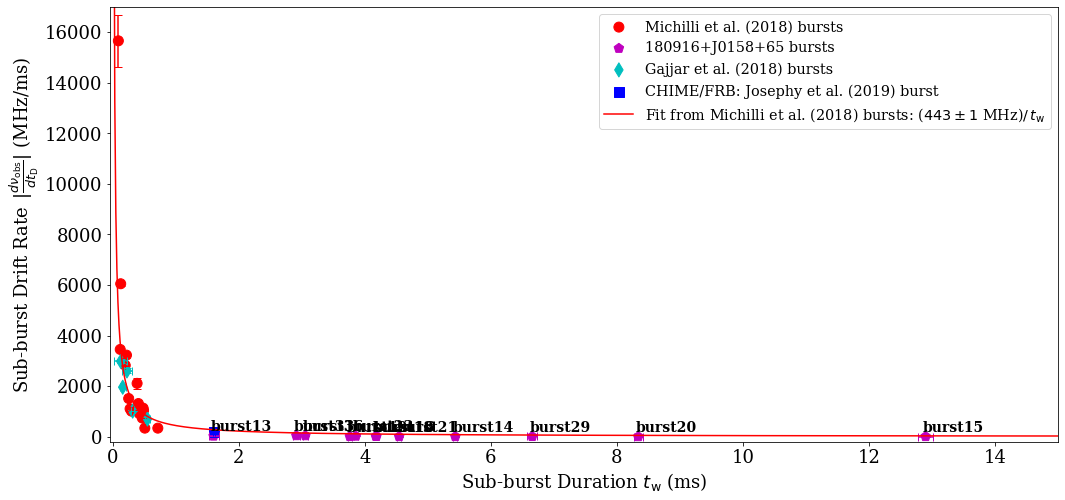

In [47]:
# Gajjar test to michili fit
plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 100
fontsize = 18
annotsize = 14
logscale = False
filename = 'log_driftvsduration' if logscale else 'driftvsduration'
figsize = (17, 8)
# figsize = (14, 10)

ax = michillibursts.plot.scatter(x='tau_w_ms', y='drift_abs', 
                               xerr=michillibursts['red_chisq']*michillibursts['tau_w_error'], yerr=michillibursts['red_chisq']*michillibursts['drift error (mhz/ms)'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o',
                               label='Michilli et al. (2018) bursts')

# for k, v in michillibursts.iterrows():
#     ax.annotate(k, (v['tau_w_ms'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
for k, v in selectbursts180916.iterrows():
    ax.annotate(k, (v['tau_w_ms'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)

selectbursts180916.plot.scatter(ax=ax, x='tau_w_ms', y='drift_abs', 
                               xerr=selectbursts180916['red_chisq']*selectbursts180916['tau_w_error'], yerr=selectbursts180916['red_chisq']*selectbursts180916['drift error (mhz/ms)'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p',
                               label='180916+J0158+65 bursts')

otherbursts.head(5).plot.scatter(ax=ax, x='tau_w_ms_corr', y='drift_corr',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_err_corr'], yerr=otherbursts['red_chisq']*otherbursts['drift_err_corr'], 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='d', label='Gajjar et al. (2018) bursts')
otherbursts.tail(1).plot.scatter(ax=ax, x='tau_w_ms_corr', y='drift_corr',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_err_corr'], yerr=otherbursts['red_chisq']*otherbursts['drift_err_corr'], 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='s', label='CHIME/FRB: Josephy et al. (2019) burst')
# for k, v in otherbursts.iterrows():
#     ax.annotate(k+'_c', (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
    
if not logscale:
    ax.set_xlim(-0.05, 15)
    ax.set_ylim(-200, 17000)
elif logscale:
    ax.set_xlim(0.05, 20)
    ax.set_ylim(10**0, 10**5/2)

# ax.set_title('Sub-burst Drift Rate vs. Burst Duration (fit to Michilli bursts)', size=fontsize)
ax.set_xlabel('Sub-burst Duration $t_\\mathrm{w}$ (ms)', size=fontsize)
ax.set_ylabel('Sub-burst Drift Rate $\,\\left|\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}}\\right|$ (MHz/ms)', size=fontsize)


# NLSQ fit
fit_sigma = michillibursts['red_chisq']*michillibursts['drift error (mhz/ms)']
popt, pcov = fitreciprocal(michillibursts['tau_w_ms'], michillibursts['drift_abs'], sigma=fit_sigma)
perr = np.sqrt(np.diag(pcov))

# NLSQ fit no errors
popt_noe, pcov_noe = fitreciprocal(michillibursts['tau_w_ms'], michillibursts['drift_abs'])
perr_noe = np.sqrt(np.diag(pcov_noe))

# NLSQ log fit
fit_sigma = michillibursts['red_chisq']*michillibursts['drift error (mhz/ms)']
popt_log, pcov_log = fitreciprocal_log(np.log(michillibursts['tau_w_ms']), np.log(michillibursts['drift_abs']), sigma=np.log(fit_sigma))
perr_log = np.sqrt(np.diag(pcov_log))

# NLSQ log fit
popt_log_noe, pcov_log_noe = fitreciprocal_log(np.log(michillibursts['tau_w_ms']), np.log(michillibursts['drift_abs']))
perr_log_noe = np.sqrt(np.diag(pcov_log_noe))

# log-log
popt_log_log, pcov_log_log = fitreciprocal_log(np.log(michillibursts['tau_w_ms']), np.log(michillibursts['drift_abs']), loglog=True)
perr_log_log = np.sqrt(np.diag(pcov_log_log))

# NLSQ linear chisq
# fit_residual = michillibursts['drift_abs'] - popt[0]/michillibursts['tau_w_ms']
# chisq = np.sum((fit_residual / fit_sigma) ** 2)
# red_chisq = chisq / (len(michillibursts['drift_abs']) - len(popt)) # this is chisq/(M-N)
# fit_error = perr*red_chisq

# ODR fit
fitdata = scipy.odr.RealData(michillibursts['tau_w_ms'], 
                             michillibursts['drift_abs'],
                             sx=michillibursts['red_chisq']*michillibursts['tau_w_error'], 
                             sy=michillibursts['red_chisq']*michillibursts['drift error (mhz/ms)'])
odrfitter = scipy.odr.ODR(fitdata, fit_model, beta0=[500])
odrfitter.set_job(fit_type=0)
odrfit = odrfitter.run()

# ODR fit log
fitdata_log = scipy.odr.RealData(np.log(michillibursts['tau_w_ms']), 
                             np.log(michillibursts['drift_abs']),
                             sx=np.log(michillibursts['red_chisq']*michillibursts['tau_w_error']), 
                             sy=np.log(michillibursts['red_chisq']*michillibursts['drift error (mhz/ms)']))
odrfitter_log = scipy.odr.ODR(fitdata_log, fit_model_log, beta0=[500])
odrfitter_log.set_job(fit_type=0)
odrfit_log = odrfitter_log.run()

# print('nlsq:', popt, perr)
# print('nlsq noe:', popt_noe, perr_noe)
# print('nlsq log:', np.exp(popt_log), np.exp(perr_log))
# print('nlsq log noe:', np.exp(popt_log_noe), np.exp(perr_log_noe))
# print('loglog:', popt_log_log, perr_log_log)
# print('odr:', odrfit.beta, odrfit.sd_beta)
# print('odr log:', np.exp(odrfit_log.beta), np.exp(odrfit_log.sd_beta))

### Plot fits
x = np.linspace(0, 20, num=1200)
opts  = [popt, popt_noe, np.exp(popt_log), np.exp(popt_log_noe), np.exp(odrfit_log.beta)]
errs  = [perr, perr_noe, np.exp(perr_log), np.exp(perr_log_noe), np.exp(odrfit_log.sd_beta)]
names = ['1. nlsq\t\t\t', '2. nlsq no error\t', '3. nlsq log\t\t', '4. nlsq log no error', '']
ls    = ['k--', 'g--', 'y-', 'g-.', 'r-']
for opt, err, name, l in zip(opts, errs, names, ls):
    if l not in ['r-']:
        continue
    plt.plot(x, opt[0]/x, l, label='Fit from Michilli et al. (2018) bursts: {}(${:.0f} \pm {:.0f}\,\,$MHz)'.format(name, opt[0], err[0])+'$/\,t_\\mathrm{w}$')

# plt.plot(x, odrfit.beta[0]/x, 'b-', label='6. x and y error \t\t${:.2f} \pm {:.2f}$'.format(odrfit.beta[0], odrfit.sd_beta[0])+'/$t_w$')

# a = np.exp(popt_log_log[1])
# k = popt_log_log[0]
# plt.plot(x, a * x**k, 'r-', label='loglog \t\t\t\t\t${:.2f}~t_w^{{{:.2f}}}$'.format(a,k))

handles, labels = ax.get_legend_handles_labels()
handles = handles [1:] + [handles[0]]
labels = labels [1:] + [labels[0]]
plt.legend(handles, labels, fontsize='x-large')

# plt.tight_layout()
# for f in ['png', 'pdf', 'eps']: plt.savefig('paper_figures/{}.{}'.format(filename, f))
plt.savefig(filename)

Below here is ??
====

C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


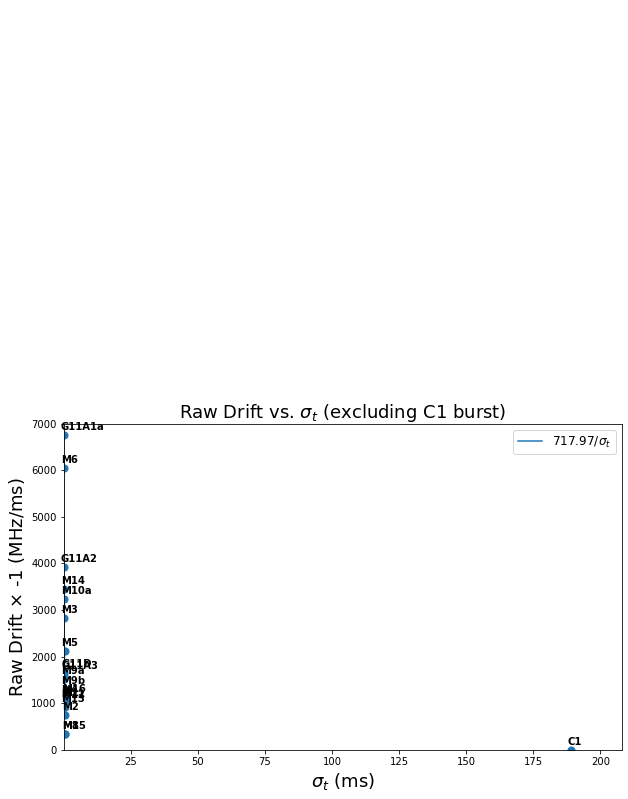

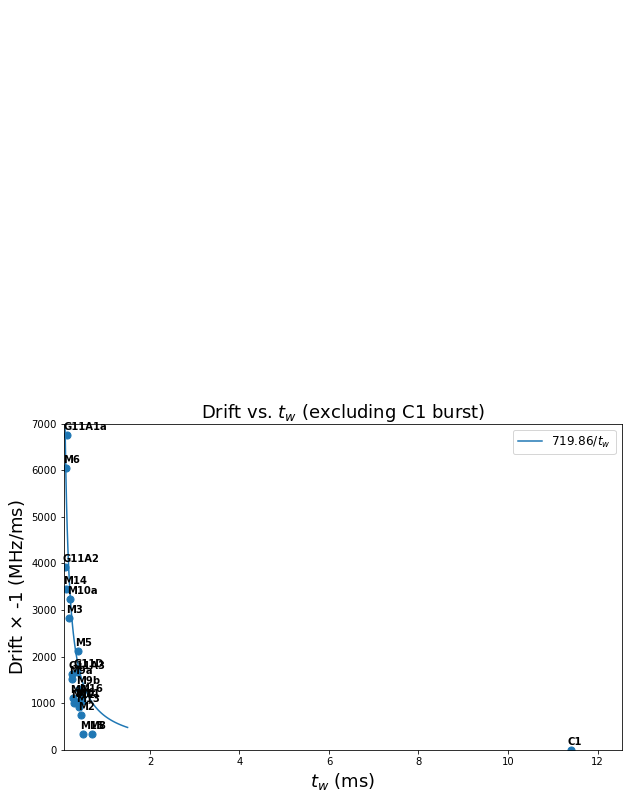

In [275]:
# all fit
ax = selectbursts.plot.scatter(x='sigma_t_ms', y='drift_abs', figsize=(10, 6), s=50)
for k, v in selectbursts.iterrows():
    ax.annotate(k, (v['sigma_t_ms'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold')
ax.set_xlim(0.9*min(selectbursts['sigma_t_ms']), 1.1*max(selectbursts['sigma_t_ms']))
ax.set_title('Raw Drift vs. $\sigma_t$ (excluding C1 burst)', size=fontsize)
ax.set_xlabel('$\sigma_t$ (ms)', size=fontsize)
ax.set_ylabel('Raw Drift $\\times$ -1 (MHz/ms)', size=fontsize)

popt, pcov = fitreciprocal(selectbursts['sigma_t_ms'], selectbursts['drift_abs'])
x = np.linspace(0, 1, num=100)
plt.plot(x, popt[0]/x, label='${:.2f}/\sigma_t$'.format(popt[0]))
plt.legend(fontsize='large')
ax.set_ylim(0, 7000)
# plt.savefig('drift_vs_sigmat.png')

ax = selectbursts.plot.scatter(x='tau_w_ms', y='drift_abs', figsize=(10, 6), s=50)
for k, v in selectbursts.iterrows():
    ax.annotate(k, (v['tau_w_ms'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold')
ax.set_xlim(0.9*min(selectbursts['tau_w_ms']), 1.1*max(selectbursts['tau_w_ms']))
# ax.set_xlim(0.9*min(selectbursts['sigma_t']), 1.1*max(selectbursts['sigma_t']))
ax.set_title('Drift vs. $t_w$ (excluding C1 burst)', size=fontsize)
ax.set_xlabel('$t_w$ (ms)', size=fontsize)
ax.set_ylabel('Drift $\\times$ -1 (MHz/ms)', size=fontsize)

popt, pcov = fitreciprocal(selectbursts['tau_w_ms'], selectbursts['drift_abs'])
x = np.linspace(0, 1.5, num=100)
plt.plot(x, popt[0]/x, label='${:.2f}$'.format(popt[0])+'/$t_w$')
plt.legend(fontsize='large')
ax.set_ylim(0, 7000)
plt.savefig('drift_vs_tw.png')

Text(0, 0.5, 'Drift $\\cdot \\overline{\\tau_{0}}/\\tau_{0}$')

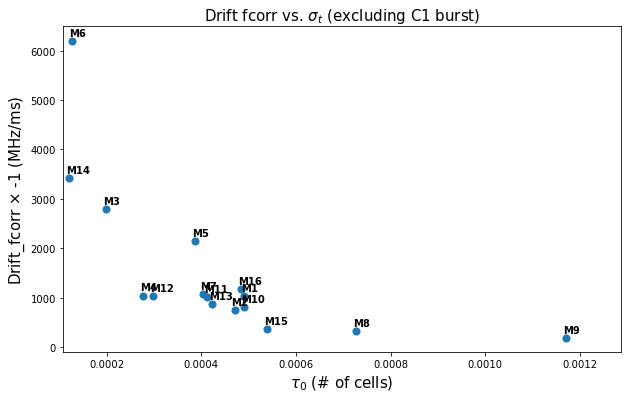

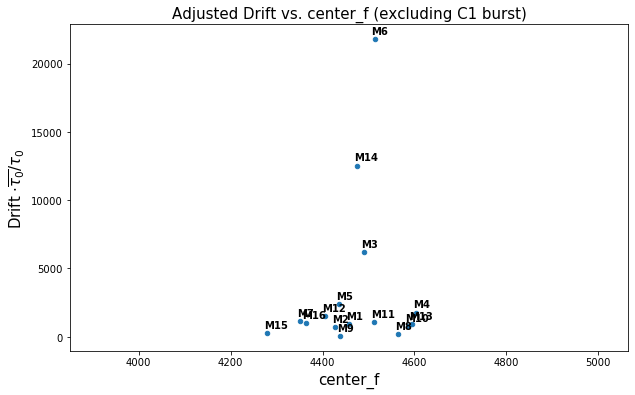

In [59]:
bursts['drift_fcorr'] = bursts['drift_abs'] * (np.mean(bursts.head(numbursts)['center_f']) /  bursts['center_f'])**2

ax = bursts.head(numbursts).plot.scatter(x='tau_0', y='drift_fcorr', figsize=(10, 6), s=50)
for k, v in bursts.head(numbursts).iterrows():
    ax.annotate(v['name'], (v['tau_0'], v['drift_fcorr']), xytext=(-3,5), textcoords='offset points', weight='bold')
ax.set_xlim(0.9*min(bursts.head(numbursts)['tau_0']), 1.1*max(bursts.head(numbursts)['tau_0']))
# ax.set_xlim(0.9*min(bursts.head(numbursts)['sigma_t']), 1.1*max(bursts.head(numbursts)['sigma_t']))
ax.set_title('Drift fcorr vs. $\sigma_t$ (excluding C1 burst)', size=fontsize)
ax.set_xlabel('$\\tau_0$ (# of cells)', size=fontsize)
ax.set_ylabel('Drift_fcorr $\\times$ -1 (MHz/ms)', size=fontsize)
# plt.savefig('drift_vs_sigmat3.png')

ax = bursts.head(numbursts).plot.scatter(x='center_f', y='drift_corr', figsize=(10, 6))
for k, v in bursts.head(numbursts).iterrows():
    ax.annotate(v['name'], (v['center_f'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold')
ax.set_xlim(0.9*min(bursts.head(numbursts)['center_f']), 1.1*max(bursts.head(numbursts)['center_f']))
ax.set_title('Adjusted Drift vs. center_f (excluding C1 burst)', size=fontsize)
ax.set_xlabel('center_f', size=fontsize)
ax.set_ylabel('Drift $\cdot \overline{\\tau_{0}}/\\tau_{0}$', size=fontsize)
# plt.savefig('adjusted_vs_centerf.png')

In [12]:
np.mean(bursts.head(numbursts)['center_f'])

4468.4997819375

<Figure size 432x288 with 0 Axes>

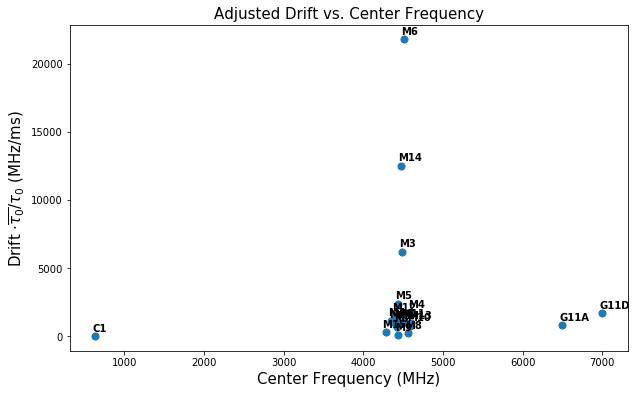

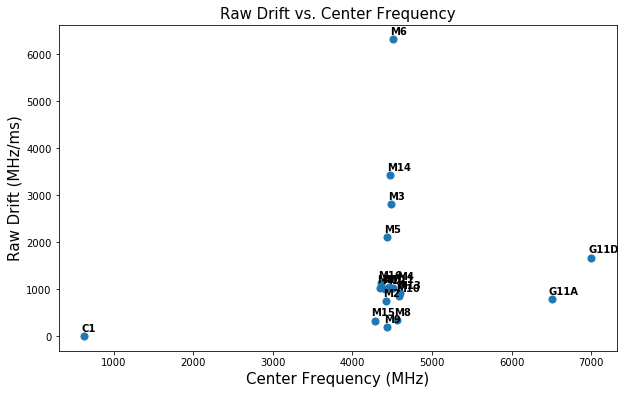

In [291]:
bursts['drift_corr']
bursts['drift_predicted'] = - bursts['center_f']**2 / bursts['tau_0']
plt.figure()
ax = bursts.plot.scatter(x='center_f', y='drift_corr', s=50, figsize=(10,6))
for k, v in bursts.iterrows():
    ax.annotate(v['name'], (v['center_f'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold')
ax.set_title('Adjusted Drift vs. Center Frequency', size=fontsize)
ax.set_xlabel('Center Frequency (MHz)', size=fontsize)
ax.set_ylabel('Drift $\cdot \overline{\\tau_{0}}/\\tau_{0}$ (MHz/ms)', size=fontsize)
plt.savefig('adjusted_vs_center.png')

ax = bursts.plot.scatter(x='center_f', y='drift_abs', s=50, figsize=(10,6))
for k, v in bursts.iterrows():
    ax.annotate(v['name'], (v['center_f'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold')
ax.set_title('Raw Drift vs. Center Frequency', size=fontsize)
ax.set_xlabel('Center Frequency (MHz)', size=fontsize)
ax.set_ylabel('Raw Drift (MHz/ms)', size=fontsize)
plt.savefig('rawdrift_vs_center.png')